# Optimizing overall number of connections (algorithm test)

<u>Goal</u>: Same overall #connections in rewired as in original connectome

ℹ️ Related ticket: https://bbpteam.epfl.ch/project/issues/browse/ACCS-46

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
save_figs = False

## Set up toy connectome and (inaccurate) conn. prob. model

* Toy connectome defined by adjacency matrix (specific instance)
* Conn. prob. model to be used for rewiring, defined by conn. prob. matrix (not entierly consistent with actual connectome)

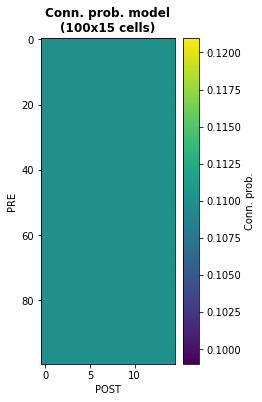

In [3]:
# Initialize model connection probabilities
N = 100 # Number of pre-neurons
M = 15 # Number of post-neurons

np.random.seed(0)
# p = np.array([0.5 * np.random.rand(N) * np.arange(N) * (m + 1) / (N * M) for m in range(M)]).T # Connection probabilities for NxM neurons with different pathway probability scalings
# p = np.array([0.5 * np.random.rand(N) * np.arange(N) / N for m in range(M)]).T # Connection probabilities for NxM neurons with same pathway probability scalings
# p = np.array([np.full(N, 0.5 * (m + 1) / M) for m in range(M)]).T # Constant connection probabilities for NxM neurons with different pathway probability scalings
p = np.array([np.full(N, 0.11) for m in range(M)]).T # Constant connection probabilities for NxM neurons with same pathway probability scalings

plt.figure(figsize=(3, 6))
plt.imshow(p, interpolation='nearest')
plt.axis('tight')
plt.xlabel('POST')
plt.ylabel('PRE')
plt.colorbar(label='Conn. prob.')
plt.title(f'Conn. prob. model\n({N}x{M} cells)', fontweight='bold')
if save_figs:
    plt.savefig('conn_prob_model.png', dpi=300)
plt.show()

INFO: #connections in original connectome: 198 (=optimization target)


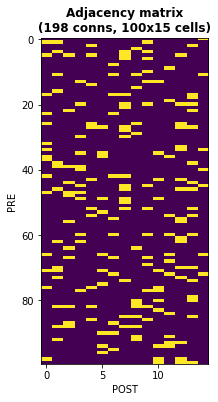

In [4]:
# Define original connectome (=optimization target), which is somewhat different from (inaccurate) model
model_mismatch_pct = -10.0
adj_orig = np.random.rand(*p.shape) < p * (1 - model_mismatch_pct / 100)
nconn_orig = np.sum(adj_orig)
print(f'INFO: #connections in original connectome: {nconn_orig} (=optimization target)')

plt.figure(figsize=(3, 6))
plt.imshow(adj_orig, interpolation='nearest')
plt.axis('tight')
plt.xlabel('POST')
plt.ylabel('PRE')
plt.title(f'Adjacency matrix\n({np.sum(adj_orig)} conns, {N}x{M} cells)', fontweight='bold')
if save_figs:
    plt.savefig('adj_mat_orig.png', dpi=300)
plt.show()

## Run rewiring without/with optimization of #connections

* Optimization goal: Matching overall numbers of connections in original and rewired connectomes
* 2-step algorithm [using only local information within a data split!!]:
  1. Matching the mean conn. prob.
  2. Matching an instance to the mean
* 2 algorithm variants:
  1. Simple:
    - Convergence with rounding required in step 1 => Convergence with rounding not always possible
    - Exact match w/o error propagation in step 2
  2. Complex:
    - Theoretical estimate in step 1
    - Exact match using error propagation in step 2 => Local error information to be passed between iterations (over post-neurons) within same data split

### Step 1: Matching the mean

<u>Goal</u>: Estimate global `p_scale` factor so that overall #connections match on average

ℹ️ Global `p_scale` factor and `estimation_run` feature available in rewiring operation

<u>Variants</u>:
  1. Estimation with rounding to integer number of pre-connections for each post-neuron (so that exact match in step 2 is possible); requires iterations until convergence (if possible)
  2. Theoretical estimate w/o rounding (exact match in step 2 only possible with error propagation); optimum value can be computed in a single step

In [5]:
# Estimate p_scale to match overall number on average
v_alg = 2 # 1 or 2
fn_prefix = f'v{v_alg}'

p_scale_steps = [1.0]
nconns_steps = []
conv_idx = None

NUM_ITER = 10
for n in range(NUM_ITER):
    p_scale = np.prod(p_scale_steps)
    assert np.max(p * p_scale) <= 1.0, 'ERROR: p out of range!'
    if v_alg == 1: # Estimate with rounding (since rewiring is done per post-neuron)
        nconns_avg = np.round(np.sum(p * p_scale, 0)).astype(int)
    elif v_alg == 2: # Theoretical scaling factor w/o rounding
        nconns_avg = np.sum(p * p_scale)
    else:
        assert False, f'ERROR: Algorithm v{v_alg} unknown!'
    nconns = np.sum(nconns_avg)
    nconns_steps.append(nconns)
    p_scale_steps.append(nconn_orig / nconns)
    if np.round(nconns).astype(int) == nconn_orig and conv_idx is None:
        conv_idx = n
        # break

if conv_idx is None:
    print(f'WARNING: p_scale not converged after {NUM_ITER} iterations ({fn_prefix})!')
p_scale = np.prod(p_scale_steps)
print(f'p_scale = {p_scale}')

p_scale = 1.2


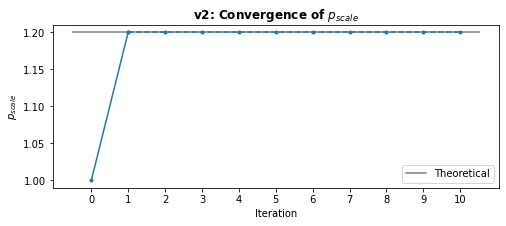

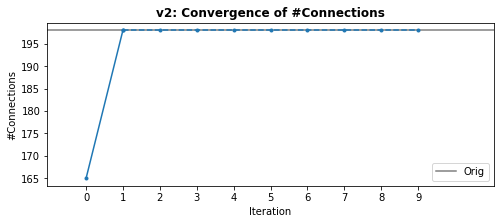

In [6]:
# Plot p_scale convergence
plt.figure(figsize=(8, 3))
if conv_idx is None:
    plt.plot(np.arange(len(p_scale_steps)), [np.prod(p_scale_steps[:i + 1]) for i in range(len(p_scale_steps))], '.-', color='tab:blue')
else:
    plt.plot(np.arange(conv_idx + 1), [np.prod(p_scale_steps[:i + 1]) for i in range(conv_idx + 1)], '.-', color='tab:blue')
    plt.plot(np.arange(conv_idx, len(p_scale_steps)), [np.prod(p_scale_steps[:i + 1]) for i in range(conv_idx, len(p_scale_steps))], '.--', color='tab:blue')
plt.plot(plt.xlim(), np.full(2, nconn_orig / np.sum(p)), '-', color='tab:grey', zorder=0, label='Theoretical')
xlim = plt.xlim()
plt.xticks(np.arange(len(p_scale_steps)))
plt.xlabel('Iteration')
plt.ylabel('$p_{scale}$')
plt.title(f'v{v_alg}: Convergence of ' + '$p_{scale}$', fontweight='bold')
plt.legend()
if save_figs:
    plt.savefig(fn_prefix + '_conv_pscale.png', dpi=300)
plt.show()

# ... and #connections convergence
plt.figure(figsize=(8, 3))
if conv_idx is None:
    plt.plot(np.arange(len(nconns_steps)), nconns_steps, '.-', color='tab:blue')
else:
    plt.plot(np.arange(conv_idx + 1), nconns_steps[:conv_idx + 1], '.-', color='tab:blue')
    plt.plot(np.arange(conv_idx, len(nconns_steps)), nconns_steps[conv_idx:], '.--', color='tab:blue')
# plt.xticks(np.arange(len(p_scale_steps)))
plt.xlim(xlim)
plt.plot(plt.xlim(), np.full(2, nconn_orig), '-', color='tab:grey', zorder=0, label='Orig')
plt.xticks(np.arange(len(nconns_steps)))
plt.xlabel('Iteration')
plt.ylabel('#Connections')
plt.title(f'v{v_alg}: Convergence of #Connections', fontweight='bold')
plt.legend()
if save_figs:
    plt.savefig(fn_prefix + '_conv_nconn.png', dpi=300)
plt.show()


### Step 2: Matching an instance to the mean

<u>Goal</u>: With `p_scale` converged, matching the number of pre-connections of an instance drawn for each post-neuron exactly to the number of connections expected on average

ℹ️ `opt_nconn` flag for rewiring operation

<u>Variants:</u>
1. `p_scale` convergence (incl. rounding) required for exact match
2. Theoretically optimal `p_scale` calculated, and propagation of error between post-iteratons

In [7]:
# Draw connections w/o optimization
NUM_INSTANCES = 1000

def draw_conns(p_pre):
    return np.random.rand(len(p_pre)) < p_pre

nconns = []
adjmats = []
np.random.seed(9999) # [Seed must be different from initial seed!!]
for n in range(NUM_INSTANCES):
    adj_rewired = np.array([draw_conns(p[:, j] * p_scale) for j in range(p.shape[1])]).T
    adjmats.append(adj_rewired)
    nconns.append(np.sum(adj_rewired))
adjmats = np.array(adjmats)
nconns = np.array(nconns)
pconns = np.sum(adjmats, 0) / NUM_INSTANCES

In [8]:
# Draw connections with optimization
# v1 ... Simple (local) optimization by selecting random instances
# v2 ... Improved version => Optimization with error propagation
# NOTE: No global information available in individual rewiring splits, so operation with local information only (within a split)!!!
#       Therefore, p must be scaled properly using the theoretical mean, based on which the conn. count is (locally) optimized within a given split.
# WARNING: Optimization based on selecting random instances, w/o changing/scaling the conn. prob. distribution!
#          Does only work as long as err is smaller than range of random variability (given OPT_NCONN_MAX_ITER)
OPT_NCONN_MAX_ITER = 100

def draw_conns_opt(p, max_iter=100):
    nconns_avg = np.round(np.sum(p)).astype(int) # Number of connections on average (=target count)
    nconns = -np.inf
    for n_opt in range(max_iter):
        conns_tmp = draw_conns(p)
        if np.abs(np.sum(conns_tmp) - nconns_avg) < np.abs(nconns - nconns_avg): # Keep closest value among all tries
            conns = conns_tmp
            nconns = np.sum(conns)
        if nconns == nconns_avg:
            break # Optimum found
    return conns

def draw_conns_opt2(p_pre, nconn_corr=0.0, max_iter=100, show_warn=True):
    nconns_avg = np.round(np.sum(p_pre) + nconn_corr).astype(int) # Number of connections on average + correction term (=target count)
    nconns = -np.inf
    for n_opt in range(max_iter):
        conns_tmp = draw_conns(p_pre)
        if np.abs(np.sum(conns_tmp) - nconns_avg) < np.abs(nconns - nconns_avg): # Keep closest value among all tries
            conns = conns_tmp
            nconns = np.sum(conns)
        if nconns == nconns_avg:
            break # Optimum found
    if nconns != nconns_avg and show_warn:
        print(f'WARNING: Opt. #conns not found within {max_iter} iterations (mismatch: {nconns - nconns_avg} conns)!')
    err = nconns - (np.sum(p_pre) + nconn_corr) # ERROR: Difference from theoretical optimum
    return conns, err

nconns_opt = []
errmat_opt = []
adjmats_opt = []
np.random.seed(9999) # [Seed must be different from initial seed!!]
for n in range(NUM_INSTANCES):
    adj_rewired = np.zeros_like(p, dtype=bool)
    curr_err = 0.0
    err_vec = np.hstack([[curr_err], np.full(p.shape[1], np.nan)])
    for j in range(p.shape[1]): # Fixed processing order
#     for j in np.random.permutation(p.shape[1]): # Randomized processing order
        if v_alg == 1:
            adj = draw_conns_opt(p[:, j] * p_scale, OPT_NCONN_MAX_ITER)
            err = np.nan
        elif v_alg == 2:
            adj, curr_err = draw_conns_opt2(p[:, j] * p_scale, -curr_err, OPT_NCONN_MAX_ITER, show_warn=False)
        else:
            assert False, f'ERROR: Algorithm v{v_alg} unknown!'
        adj_rewired[:, j] = adj
        err_vec[j + 1] = curr_err
    adjmats_opt.append(adj_rewired)
    nconns_opt.append(np.sum(adj_rewired))
    errmat_opt.append(err_vec)
adjmats_opt = np.array(adjmats_opt)
nconns_opt = np.array(nconns_opt)
errmat_opt = np.array(errmat_opt)
pconns_opt = np.sum(adjmats_opt, 0) / NUM_INSTANCES

mm = nconns_opt - nconn_orig # Mismatch from orig #conn
mm_cnt = np.sum(mm != 0) # Mismatch count (instances)
if mm_cnt > 0:
    print(f'WARNING: #connections does not match original ({nconn_orig} conns) in {mm_cnt} of {NUM_INSTANCES} instances (Mismatch: min/max {np.min(mm)}/{np.max(mm)} conns)!')
else:
    print(f'INFO: #connections matches original ({nconn_orig} conns) in all {NUM_INSTANCES} instances!')

# IDEA for improvement (v2 opt):
#   - Randomize rewiring order of POST-neurons within split, so that order of error propagation is different in different instances

INFO: #connections matches original (198 conns) in all 1000 instances!


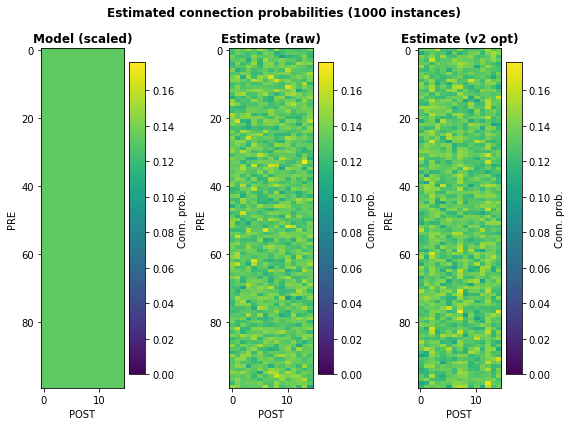

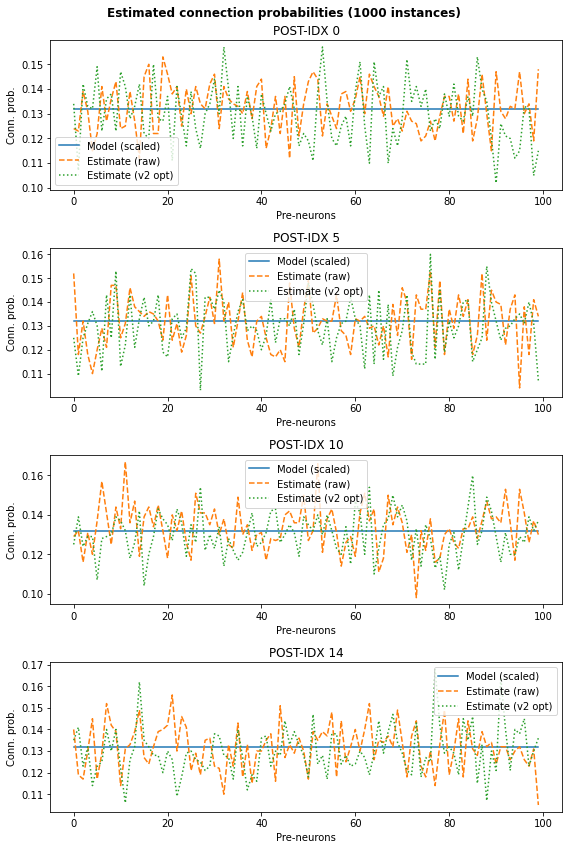

In [9]:
# Compare estimated conn. probs. with actual (scaled!) one
plim = np.max([np.max(p * p_scale), np.max(pconns), np.max(pconns_opt)])
plt.figure(figsize=(8, 6))
plt.subplot(1, 3, 1)
plt.imshow(p * p_scale, interpolation='nearest', vmin=0.0, vmax=plim)
plt.axis('tight')
plt.xlabel('POST')
plt.ylabel('PRE')
plt.colorbar(label='Conn. prob.')
plt.title('Model (scaled)', fontweight='bold')

plt.subplot(1, 3, 2)
plt.imshow(pconns, interpolation='nearest', vmin=0.0, vmax=plim)
plt.axis('tight')
plt.xlabel('POST')
plt.ylabel('PRE')
plt.colorbar(label='Conn. prob.')
plt.title('Estimate (raw)', fontweight='bold')

plt.subplot(1, 3, 3)
plt.imshow(pconns_opt, interpolation='nearest', vmin=0.0, vmax=plim)
plt.axis('tight')
plt.xlabel('POST')
plt.ylabel('PRE')
plt.colorbar(label='Conn. prob.')
plt.title(f'Estimate (v{v_alg} opt)', fontweight='bold')

plt.suptitle(f'Estimated connection probabilities ({NUM_INSTANCES} instances)', fontweight='bold')
plt.tight_layout()
if save_figs:
    plt.savefig(fn_prefix + '_conn_prob_estim.png', dpi=300)
plt.show()

# Plot selected examples
post_sel = [0, np.round(M / 3).astype(int), 2 * np.round(M / 3).astype(int), M - 1]
plt.figure(figsize=(8, 12))
for i, pidx in enumerate(post_sel):
    plt.subplot(len(post_sel), 1, i + 1)
    plt.plot(p[:, pidx] * p_scale, color='tab:blue', label='Model (scaled)')
    plt.plot(pconns[:, pidx], '--', color='tab:orange', label='Estimate (raw)')
    plt.plot(pconns_opt[:, pidx], ':', color='tab:green', label=f'Estimate (v{v_alg} opt)')
    plt.xlabel('Pre-neurons')
    plt.ylabel('Conn. prob.')
    plt.title(f'POST-IDX {pidx}')
    plt.legend()
plt.suptitle(f'Estimated connection probabilities ({NUM_INSTANCES} instances)', fontweight='bold')
plt.tight_layout()
if save_figs:
    plt.savefig(fn_prefix + '_conn_prob_estim_sel.png', dpi=300)
plt.show()

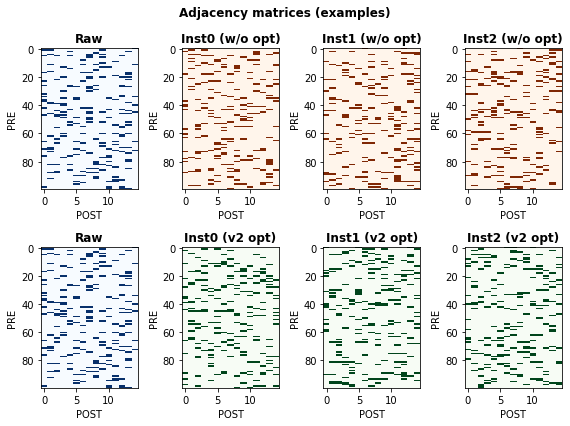

In [10]:
# Plot actual connectomes (examples)
num_inst = 3

plt.figure(figsize=(8, 6))
for i in [1, num_inst + 2]:
    plt.subplot(2, 1 + num_inst, i)
    plt.imshow(adj_orig, interpolation='nearest', cmap=plt.cm.Blues)
    plt.axis('tight')
    plt.xlabel('POST')
    plt.ylabel('PRE')
    plt.title('Raw', fontweight='bold')

for i in range(num_inst):
    plt.subplot(2, 1 + num_inst, 2 + i)
    plt.imshow(adjmats[i, :, :], interpolation='nearest', cmap=plt.cm.Oranges)
    plt.axis('tight')
    plt.xlabel('POST')
    plt.ylabel('PRE')
    plt.title(f'Inst{i} (w/o opt)', fontweight='bold')

for i in range(num_inst):
    plt.subplot(2, 1 + num_inst, num_inst + 3 + i)
    plt.imshow(adjmats_opt[i, :, :], interpolation='nearest', cmap=plt.cm.Greens)
    plt.axis('tight')
    plt.xlabel('POST')
    plt.ylabel('PRE')
    plt.title(f'Inst{i} (v{v_alg} opt)', fontweight='bold')

plt.suptitle('Adjacency matrices (examples)', fontweight='bold')
plt.tight_layout()
if save_figs:
    plt.savefig(fn_prefix + '_adj_sel.png', dpi=300)
plt.show()

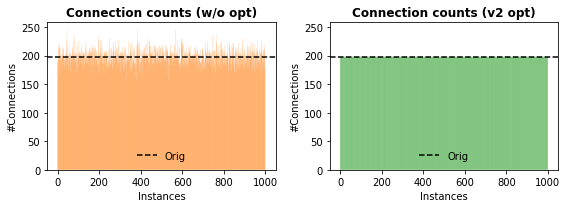

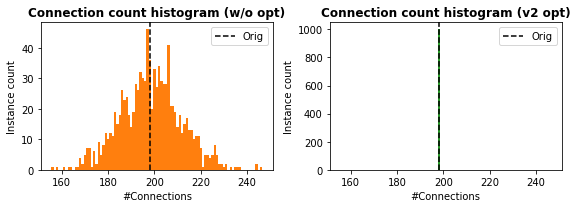

In [11]:
# Plot and connection counts
plt.figure(figsize=(8, 3))
plt.subplot(1, 2, 1)
plt.bar(np.arange(len(nconns)), nconns, align='edge', snap=False, color='tab:orange')
plt.xlim(plt.xlim())
ylim = plt.ylim()
plt.plot(plt.xlim(), np.full(2, nconn_orig), 'k--', label='Orig')
plt.xlabel('Instances')
plt.ylabel('#Connections')
plt.title('Connection counts (w/o opt)', fontweight='bold')
plt.legend(loc='lower center', frameon=False)

plt.subplot(1, 2, 2)
plt.bar(np.arange(len(nconns_opt)), nconns_opt, align='edge', snap=False, color='tab:green')
plt.xlim(plt.xlim())
plt.plot(plt.xlim(), np.full(2, nconn_orig), 'k--', label='Orig')
plt.ylim(ylim)
plt.xlabel('Instances')
plt.ylabel('#Connections')
plt.title(f'Connection counts (v{v_alg} opt)', fontweight='bold')
plt.legend(loc='lower center', frameon=False)
plt.tight_layout()
if save_figs:
    plt.savefig(fn_prefix + '_nconn_counts.png', dpi=300)
plt.show()

# ... and connection count histograms
cnt_bins = np.arange(np.min(nconns) - 0.5, np.max(nconns) + 1.5, 1)
plt.figure(figsize=(8, 3))
plt.subplot(1, 2, 1)
plt.hist(nconns, cnt_bins, color='tab:orange')
plt.ylim(plt.ylim())
plt.plot(np.full(2, nconn_orig), plt.ylim(), 'k--', label='Orig')
plt.xlabel('#Connections')
plt.ylabel('Instance count')
plt.title('Connection count histogram (w/o opt)', fontweight='bold')
plt.legend()

plt.subplot(1, 2, 2)
plt.hist(nconns_opt, cnt_bins, color='tab:green')
plt.ylim(plt.ylim())
plt.plot(np.full(2, nconn_orig), plt.ylim(), 'k--', label='Orig')
plt.xlabel('#Connections')
plt.ylabel('Instance count')
plt.title(f'Connection count histogram (v{v_alg} opt)', fontweight='bold')
plt.legend()
plt.tight_layout()
if save_figs:
    plt.savefig(fn_prefix + '_nconn_hist.png', dpi=300)
plt.show()

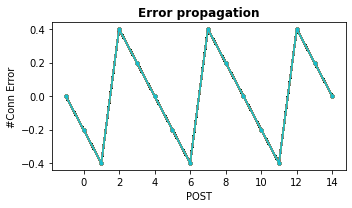

In [12]:
# Plot propagated error (mismatch from mean; v2 only)
if v_alg == 2:
    plt.figure(figsize=(5, 3))
    plt.plot(np.arange(-1, M), errmat_opt.T, '.-')
    plt.xlabel('POST')
    plt.ylabel('#Conn Error')
    plt.title('Error propagation', fontweight='bold')
    plt.tight_layout()
    if save_figs:
        plt.savefig(fn_prefix + '_error.png', dpi=300)
    plt.show()

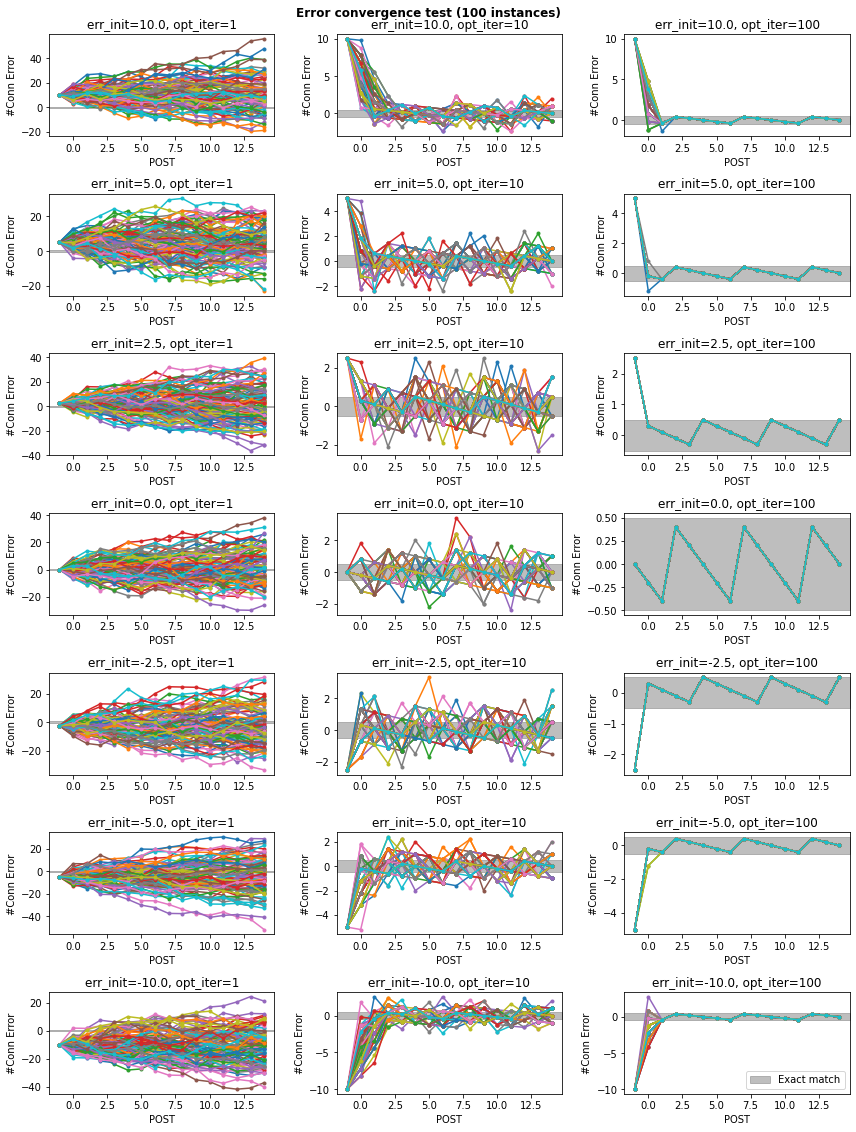

In [13]:
# Check convergence from different initial errors (v2 only)
def check_err_conv(p, num_inst, num_opt_iter, err_init):
    errmat_opt = []
    for n in range(num_inst):
        adj_rewired = np.zeros_like(p, dtype=bool)
        curr_err = err_init
        err_vec = np.hstack([[curr_err], np.full(p.shape[1], np.nan)])
        for j in range(p.shape[1]): # Fixed processing order
    #     for j in np.random.permutation(p.shape[1]): # Randomized processing order
            _, curr_err = draw_conns_opt2(p[:, j] * p_scale, -curr_err, num_opt_iter, show_warn=False)
            err_vec[j + 1] = curr_err
        errmat_opt.append(err_vec)
    errmat_opt = np.array(errmat_opt)
    return errmat_opt

if v_alg == 2:
    NUM_TEST_INSTANCES = 100
    np.random.seed(9999) # [Seed must be different from initial seed!!]
    err_vals = [10.0, 5.0, 2.5, 0.0, -2.5, -5.0, -10.0]
    itr_vals = [1, 10, 100]
    plt.figure(figsize=(12, 16))
    for i, init in enumerate(err_vals):
        for j, itr in enumerate(itr_vals):
            errmat_test = check_err_conv(p, NUM_TEST_INSTANCES, itr, init)
            plt.subplot(len(err_vals), len(itr_vals), i * len(itr_vals) + j + 1)
            plt.plot(np.arange(-1, M), errmat_test.T, '.-')
            plt.xlim(plt.xlim())
            plt.fill_between(plt.xlim(), np.full(2, -0.5), np.full(2, 0.5), color='tab:grey', alpha=0.5, label='Exact match')
            plt.xlabel('POST')
            plt.ylabel('#Conn Error')
            plt.title(f'err_init={init}, opt_iter={itr}')
    plt.legend()
    plt.suptitle(f'Error convergence test ({NUM_TEST_INSTANCES} instances)', fontweight='bold')
    plt.tight_layout()
    if save_figs:
        plt.savefig(fn_prefix + '_conv_test.png', dpi=300)
    plt.show()

In [14]:
assert False, 'STOP HERE'

AssertionError: STOP HERE

In [ ]:
# Example: Convergence of error when initialized with err = 10.0 (OPT_NCONN_MAX_ITER = 100)
plt.figure()
plt.plot(errmat_opt2.T)
plt.show()

In [ ]:
# Example: Convergence of error when initialized with err = 10.0 (OPT_NCONN_MAX_ITER = 50)
plt.figure()
plt.plot(errmat_opt2.T)
plt.show()

In [ ]:
# Example: Convergence of error when initialized with err = 10.0 (OPT_NCONN_MAX_ITER = 10)
plt.figure()
plt.plot(errmat_opt2.T)
plt.show()

In [ ]:
### OLD CODE ###
# (Corresponding to Variant 1 - Step 2)

In [ ]:
# Initialize connection probabilities
N = 100 # Number of pre-neurons

np.random.seed(0)
p = np.random.rand(N) * np.arange(N) / N # Connection probabilities for N pre-neurons
# p = np.full(N, 0.11) # Connection probabilities for N pre-neurons (constant)
nconns_avg = np.round(np.sum(p)).astype(int)

In [ ]:
# Draw connections K times w/o optimization
K = 1000
def draw_conns(p):
    return np.random.rand(len(p)) < p

conns = np.array([draw_conns(p) for k in range(K)])
p_conns = np.sum(conns, 0) / K

In [ ]:
# Draw connections K times with optimization
OPT_NCONN_MAX_ITER = 1000
def draw_conns_opt(p):
    nconns_avg = np.round(np.sum(p)).astype(int) # Number of connections on average (=target count)
    nconns = -np.inf
    for n_opt in range(OPT_NCONN_MAX_ITER):
        conns_tmp = draw_conns(p)
        if np.abs(np.sum(conns_tmp) - nconns_avg) < np.abs(nconns - nconns_avg): # Keep closest value among all tries
            conns = conns_tmp
            nconns = np.sum(conns)
        if nconns == nconns_avg:
            break # Optimum found
    return conns

conns_opt = np.array([draw_conns_opt(p) for k in range(K)])
p_conns_opt = np.sum(conns_opt, 0) / K

In [ ]:
# Plot connection probabilities
plt.figure(figsize=(8, 3))
plt.plot(p, color='tab:blue', label='Ground truth')
plt.plot(p_conns, '--', color='tab:orange', label='Estimate (raw)')
plt.plot(p_conns_opt, ':', color='tab:green', label='Estimate (opt)')
plt.xlabel('Pre-neurons')
plt.ylabel('Conn. prob.')
plt.title(f'Estimated connection probabilities ({K} instances)', fontweight='bold')
plt.legend()
plt.tight_layout()
if save_figs:
    plt.savefig('check_opt_nconn_prob.png', dpi=300)
plt.show()

# ... and actual connections
plt.figure(figsize=(8, 3))
plt.subplot(1, 2, 1)
plt.imshow(conns, interpolation='nearest', cmap=plt.cm.Oranges)
plt.axis('tight')
plt.xlabel('Pre-neurons')
plt.ylabel('Instances')
plt.title('Connections (raw)', fontweight='bold')

plt.subplot(1, 2, 2)
plt.imshow(conns_opt, interpolation='nearest', cmap=plt.cm.Greens)
plt.axis('tight')
plt.xlabel('Pre-neurons')
plt.ylabel('Instances')
plt.title('Connections (opt)', fontweight='bold')
plt.tight_layout()
if save_figs:
    plt.savefig('check_opt_nconn_conns.png', dpi=300)
plt.show()

# ... and connection counts
plt.figure(figsize=(8, 3))
plt.subplot(1, 2, 1)
plt.bar(np.arange(conns.shape[0]), np.sum(conns, 1), align='edge', snap=False, color='tab:orange')
plt.xlim(plt.xlim())
ylim = plt.ylim()
plt.plot(plt.xlim(), np.full(2, nconns_avg), 'k--', label='Average')
plt.xlabel('Instances')
plt.ylabel('#Connections')
plt.title('Connection counts (raw)', fontweight='bold')
plt.legend(loc='lower center', frameon=False)

plt.subplot(1, 2, 2)
plt.bar(np.arange(conns_opt.shape[0]), np.sum(conns_opt, 1), align='edge', snap=False, color='tab:green')
plt.xlim(plt.xlim())
plt.plot(plt.xlim(), np.full(2, nconns_avg), 'k--', label='Average')
plt.ylim(ylim)
plt.xlabel('Instances')
plt.ylabel('#Connections')
plt.title('Connection counts (opt)', fontweight='bold')
plt.legend(loc='lower center', frameon=False)
plt.tight_layout()
if save_figs:
    plt.savefig('check_opt_nconn_count.png', dpi=300)
plt.show()

# ... and #connection histograms
cnt_bins = np.arange(0.5, 2 * nconns_avg + 0.5, 1)
plt.figure(figsize=(8, 3))
plt.subplot(1, 2, 1)
plt.hist(np.sum(conns, 1), cnt_bins, color='tab:orange')
plt.ylim(plt.ylim())
plt.plot(np.full(2, nconns_avg), plt.ylim(), 'k--', label='Average')
plt.xlabel('#Connections')
plt.ylabel('Instance count')
plt.title('Connection count histogram (raw)', fontweight='bold')
plt.legend()

plt.subplot(1, 2, 2)
plt.hist(np.sum(conns_opt, 1), cnt_bins, color='tab:green')
plt.ylim(plt.ylim())
plt.plot(np.full(2, nconns_avg), plt.ylim(), 'k--', label='Average')
plt.xlabel('#Connections')
plt.ylabel('Instance count')
plt.title('Connection count histogram (opt)', fontweight='bold')
plt.legend()
plt.tight_layout()
if save_figs:
    plt.savefig('check_opt_nconn_hist.png', dpi=300)
plt.show()